# Homework 2
## 7 Convelutional Neural Networks
### 7.1 From Fully Connected Layers to Convolution

Lets say we have a fully labeled collection of one-megapixel photographs of cats and dogs to distinguish. This is $10^6$ x $10^3$ = $10^9$ parameters. This is an unfeasable amount of parameters to learn.
As such we employ convolutional neural networks as a way to exploit the known structure in natural images

Take Where's Waldo, what Waldo looks like does not depend on Waldo's location. We could break the image into patches and assign a score to each patch, and CNNs systematize this idea of spacial invariance.

We can now make intuitions:
In earlier layers, our network should respond similarly to the same patch, regardless of where it is in the images, focusing on local reigions. Deeper layer should aim to capture longer rage features of the image.

We start by representing the image X and intermediate hidden representation H as matrices, both with the same shape. X[i,j] and H[i,j] denotes pixel location.

H[i,j] = U[i,j] + sum_a( sum_b( V[i,j,a,b] X[i+a, j+b])) Where U contains biases and V is weights. becase we have i+a and j+b we can run over positive and negative offsets centered around i,j.

For this single layer we now need $10^12$ parameters.

First Principle: Translation invariance means that a shift in X should result in a shift in H, which is only possible if V and U do not depend on [i,j]. We simplyify U to constant u and remove i and j from V:

H[i,j] = u + sum_a( sum_b( V[a,b] X[i+a, j+b])) This is a convolution, as we are weight pixels at i+a and j+b to obtain H[i,j] using V[a,b]. As we remove V depending on the location and simplifying U, we reduce the number of paramters from $10^12$ to 4 x $10^6$

Second Principle: Locality, we should not have to look far from [i,j] to glean relegant information, as such outputide some range |a| > $\Delta$ or |b| > $\Delta$ V[a,b] = 0.


H[i,j] = u + sum[a = - $\Delta$ to $\Delta$]( sum[b = - $\Delta$ to $\Delta$]( V[a,b] X[i+a, j+b]))
This reduces parameters from 4 x $10^6$ to 4 $\Delta^2$, where $\Delta$ is typically smaller than 10.

With this we have reduced an image from billions of paramaeters to just several hundred, without altering dimensionality. However now this exclusivly works on local areas, we must interleave nonlinearities and convolutional layers repeatedly to account for deeper layers needing to generalise the entire image.

However this is entirely based on non-colour images, if we include 3 channel colours instead of V[a,b] we now have V[a,b,c]. Additionally we want an entire vector of hidden representations to correspond to each spatial location. So we now have

H[i,j] = u + sum[a = - $\Delta$ to $\Delta$]( sum[b = - $\Delta$ to $\Delta$]( sum[c]( V[a,b,c,d] X[i+a, j+b, c])))

where d index the output channels in hidden representations H

### 7.2 Convolutions for Images

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# take a matrix and multiply by kernal gives new matrix size n[h] x n[w] minus convolution kernel k[h] x k[w]:
# (n[h] - k[h] + 1) x (n[w] - k[w] + 1)

def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
# Convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce and output, inputs of a convolutional layer are kernel and scalar bias

class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
# here is a simple application, detecting the edge of an object by finding the first pixel change

X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
# kernel with height 1 and width 2, if horizontally adjacent elements are the same, output is 0, otherwize non-zero

K = torch.tensor([[1.0, -1.0]])

In [7]:
# 1 from white to black, -1 from black to white
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
# if we apply the kernel to transposed image we get nothing as it cannot detect vertical edges
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
# this system is greate if we know what we are looking for, however at larger kernels and sucessive convolutions, it may be impossible to precisly specify what each filter should be doing.

# attemping to learn the kernel


# two dimensional convolutional layer, kernel shape 1x2
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# four dimensional input, 1 dimensional output
# (batch size, channel, height, width), batch size and channels are 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
# learning rate
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # update kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 17.597
epoch 4, loss 5.814
epoch 6, loss 2.148
epoch 8, loss 0.841
epoch 10, loss 0.338


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0471, -0.9279]])

### 7.3 Padding and Stride

In [11]:
# if we start off with a 240x240 image, 10 layers of 5x5 convolutions, we reduce the image too 200x200
import torch
from torch import nn

In [12]:
# we can pad a 3x3 input to 5x5, and output a 4x4 matrix if we use a 2x2 kernel. As such we use kenerls with odd width and height to retain dimensionality after padding

# here is a convolutional layer with height and width of 3, apply 1 pixel padding. Given input with height and width of 8, we find output is also 8
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # strip batch size and channels
    return Y.reshape(Y.shape[2:])

# padding 1 row/column each side
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [13]:
# kernel height 5, width 3
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
# instead of moving 1 by 1 by 1 pixel each time, we could skip a pixel or two, this is defined by stride. This will decrease the dimensionality of the output
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape
# in this case input height and width is halved as a result

torch.Size([4, 4])

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 7.4 Multiple Input and Multiple Output Channcels

In [16]:
# previously we just considered multiple input and output as multiple single input and output. This allowed us to represent data as two-dimensional tensors
# Adding additional channels transforms it into tree-dimensional tensor. We will look at convolutional kernels with multiple input and output channels
import torch
from d2l import torch as d2l

In [17]:
# we need our kernal to have the same number of channels as input. 
# we use this to perform cross-correlation with input data

def corr2d_multi_in(X, K):  # perform cross correlation per channel and add them up.
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [18]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [19]:
# it is essential to have multiple channels at each layer. In most popular models we increase channel dimension as we go deeper.
# the shape of the kernel is co x ci x kh x kw. co and ci are input and output channels, kh and kw are height and width of kernel

def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [20]:
# triviual kernel with three output channels
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [22]:
# 1 x 1 kernel

def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X) # matrix multiplication in fully connected layer
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

### 7.5 Pooling

In [23]:
# pooling layers serves the dual purpose of mitigating the sensetivity of convolutional layers to location, and of spacially downsampling representations

import torch
from torch import nn
from d2l import torch as d2l

In [24]:
# average pooling takes the average of the elements in the pooling window and reduces the dimensionality
# max pooling takes the maximum of all the elements in the pooling window

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [25]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [26]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [27]:
# as with convolutional layers, we can adjust the shape through padding and stride
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [28]:
# with a pooling window of (3, 3), we get a stride shape of (3, 3)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [29]:
# we can have arbitary rectangular pooling windows too
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [30]:
# for multiple layers it processes each layer individually
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### 7.6 Convolutional Neural Networks

In [32]:
import torch
from torch import nn
from d2l import torch as d2l

In [33]:
# initialize weights
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

# LeNet 5 model
class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [34]:
# summary of all the layer sizes
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


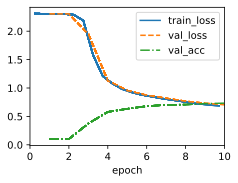

In [35]:
# training LeNet
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### 8.2 Networks Using Blocks

In [36]:
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
# the design of nerual network architectures has grown more abstract, moving from individual neurons to layers, and now to blocks
# a CNN is a sequence of convolutional layers, nonlinear activation functions, and pooling layers. One of the problems with this is that the spatial resolution decreases quite rapidly.
# One key idea is to use multiple convolutions in between downsampling, i.e. two 3x3 convolutions touches the same amount of pixels as a single 5x5 convolution does, but with fewer parameters. Deep narrow networks out perform shallow wide networks.

# VGG consists of a sequence of convolutions with 3x3 layers with padding of 1 to keep height and weidth. Followed by a 2x2 max-pooling layer with stride of 2, halving height and width
# this code is to implement one VGG block

def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


In [38]:
# one major advantage is that it is primarily composed of these blocks, compared to other models where each layer is unique
# VGG defines a family of networks rather than a specific manifestation, and we can modify the number of convolutional layers and output channels.
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [39]:
# the original VGG network had 5 convolutional blocks, the first two with one convolutional layer each, and the remaining three with two convolutional layers each.
# the first block has 64 output channels and each subsequent block doubles the number of output channels, up to 512.
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


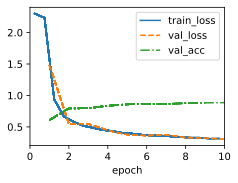

In [40]:
# we are training here with a smaller number of channels to decrease computation time

model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.6 Residual Networks

In [41]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

It is important to know how adding layers can increase complexity and expressibeness of the network, and design networks where adding layers makes networks more expressive rather than just different.

If larger function classes contain smaller ones, we are guaranteed that increasing them strictly increases expressive power of a network. For deep neural networks, if we can train the newly added layer into an identiy function, the new model will be just as effective as the original

This leads to the discovery of a residual block. If we have f(x) where x is the input, the activation function must directly learn from x, however if we take the residual mapping g(x) = f(x) - x we may be able to learn better, with the ideal of f(x) = x or g(x) = 0. As such we only need to push weights and biases of the upper weight layer to zero.

In [42]:
# ResNet has VGG's 3x3 design, where the residual block has two 3x3 convolutional layers. Each *convolutional* layer is followed by a batch normalization layer and ReLU activation function. Then, we skip these operations and add the input directly before the final ReLU activation function. This means the input and output must be the same shape

# the residual block
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [43]:
# where 1x1 convolution is not needed
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [44]:
# where 1x1 convolution is needed, halve output height and width while increasing output channels
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [45]:
# 7x7 convolutional layer with 64 output channels and stride of 2, followed by a 3x3 max pooling layer with stride of 2
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [46]:
# four modules made up of residual blocks
# retains the same height and width, but doubles the number of channels
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [47]:
# average pooling layer followed by fully connected layer output
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)
# there are four convelutional layers in each module, with the first 7x7 convolutional layer and final fully connected layer, there are 18 layers in total.

In [48]:
# shape changes
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


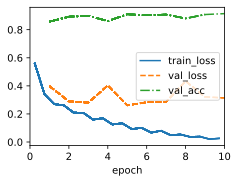

In [49]:
# training
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [50]:
# ResNeXt splits the input into multiple paths/groups. In Resnet, no information is exchanged between groups, and the output is the sum of outputs for all groups. ResNeXt amends this by using 3x3 kernels sandwitched between two 1x1 convolutions

# this implementation takes argument groups g, with bot_channels b
class ResNeXtBlock(nn.Module):
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [51]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])